# Weather station data preprocessing

If you have weather station data that is just awfully formatted, you are in the right place. Sorry about that. 

If your weather station data is ugly but is contained (A) within a single file and (B) doesn't have any major outage periods, you can skip this step and go straight to process_AWS.

This notebook will roughly walk you through the following: 
1. Manually renaming columns (e.g., if columns were named with codes or ID numbers rather than readable variables)
2. Combining multiple files into one consistent file (e.g., if files were saved one year at a time, or if they were saved each time the station was visited)
3. Identifying periods where there is enough data to justify forcing PEBSI with the data.

At the end you will generate clean files that are ready for the actual data cleaning process in process_AWS.ipynb.

In [108]:
import numpy as np
import os
import xarray as xr
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Set-up: Define variables
Fill out the cell below to set up the glacier being accessed and the filepaths. "folder" should be a folder containing only the files you wish to concatenate.

In [ ]:
# FILEPATHS
data_fp = '../../../climate_data/AWS/Raw/'          # Filepath to the folder of input data
folder = data_fp + 'kahiltna/NPS/'                  # Filepath of the folder containing the messy files
file_type = 'csv'                                   # Choose the file type (csv, txt or xlsx)

The following block produces a dataframe from all concatenated files and renames the columns. In the example, the data had unnamed columns, so the variables were manually named in col_names. You will need to edit this code to get the right column names and the right time format. You should end up with one dataframe with human-readable column names for each variable.

In [110]:
# Concatenate files in folder
fn_list = os.listdir(folder)
fn_list = [f for f in fn_list if (file_type in f) and ('preprocessed' not in f)]

col_names = ['DateTime','Pressure','Temperature','RH','Wind','Gust','Winddir','SWin','SWout','LWin','LWout']
for fn in fn_list:
    # Open the file
    if file_type in ['txt','csv']:
        df = pd.read_csv(folder + fn, index_col=0,          # Base arguments, assumes column 0 is the datetime
                            # sep='\t',                   # Delimiter/separater
                            skiprows=0,                 # How many rows of metadata
                            encoding='ISO-8859-1',      # Encoding
                            engine='python',            # Engine to open the file
                            # names = col_names           # Specify the names of the columns
                            ) 
    elif file_type in 'xlsx':
        df = pd.read_excel(folder + fn, index_col=0,
                           skiprows=1,
                           sheet_name='sheet_name')
    
    # Get timezone
    # with open(folder + fn, 'r') as f:
    #     lines = f.readlines()
    # second_line = lines[1]
    # zone_minutes = int(second_line.split('UTC')[-1].split(' ')[1])
    # timezone = pd.Timedelta(minutes=zone_minutes)
    timezone = pd.Timedelta(hours=-8)

    # Skip empty files
    if len(df.index) == 0:
        continue
    
    # Process the datetime column to be in the right format
    # if len(str(df.index[0])) > 8:
    #     df.index = pd.to_datetime(df.index, format='%m/%d/%y %H:%M:%S') - timezone
    # else:
    #     df.index = pd.to_datetime(df.index, format='%m/%d/%y') - timezone
    df.index = pd.to_datetime(df.index) - timezone

    # Concatenate files
    if fn == fn_list[0]:
        df_all = df.copy(deep=True)
    else:
        df_all = pd.concat([df_all, df],axis=0)
df_all = df_all.sort_index()
df_all = df_all[pd.to_datetime(df_all.index).second == 0]
df_all = df_all[['AirTemp_C_Avg']]
df_all.index.name = 'datetime'
# remove duplicates
df_all = df_all.astype(float).groupby(df_all.index).mean()
df_all = df_all[df_all > -100]
df_all

,AirTemp_C_Avg
datetime,
2016-05-13 22:00:00,2.209
2016-05-13 23:00:00,1.787
2016-05-14 00:00:00,0.712
2016-05-14 01:00:00,-0.021
2016-05-14 02:00:00,-0.415
...,...
2019-03-11 03:00:00,-19.330
2019-03-11 04:00:00,-19.330
2019-03-11 05:00:00,-19.320


## Inspect data fullness

This plot can help you decide whether to process the data all together or split it into separate files (e.g., if there is a large data gap)

In [111]:
# Print data counts
df_all.count()

AirTemp_C_Avg    11184
dtype: int64

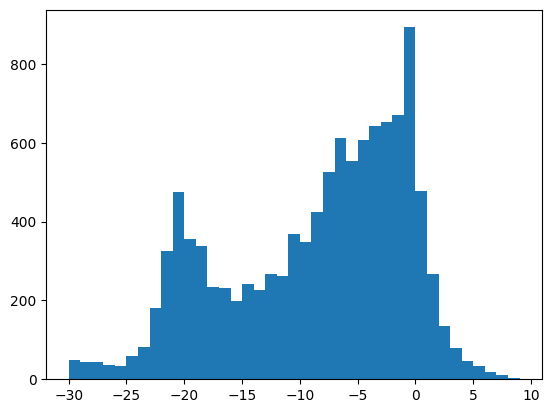

In [121]:
bins = np.arange(-30, 10, 1)
plt.hist(df_all.values, bins=bins)
plt.show()

In [91]:
# optionally drop outgoing fluxes if you want to calculate albedo/surface temperature 
# (comment this block if you want to keep that data or don't have those variables)
# df_all = df_all.drop(columns=['SWout','LWout'])

Create a plot that shows over the entire time period where all variables were measured

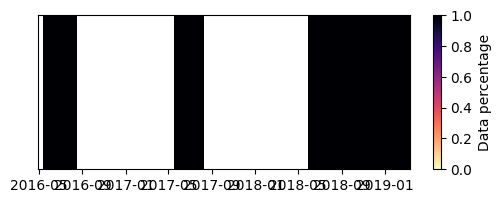

In [92]:
# this block takes a minute to run so you may want to set plot=False if rerunning the notebook multiple times
plot = True
if plot:
    fig, ax = plt.subplots(figsize=(6,2))
    all_percentage = []
    
    # check how many variables are full in each timestep
    for row in df_all.index:
        percent = df_all.loc[row].count() / len(df_all.columns)
        all_percentage.append(percent)
    all_percentage = np.array(all_percentage)
    
    # define colormap
    cmap = plt.get_cmap('magma_r')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    # plot bars for each timestep
    ax.bar(df_all.index, 1, pd.Timedelta(hours=1), color=cmap(norm(all_percentage)))

    # beautify plot
    ax.set_xlim(df_all.index[0], df_all.index[-1])
    ax.set_ylim(0,1)
    ax.set_yticks([])
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Data percentage',orientation='vertical')
    plt.show()

The function find_data_periods will find periods of a certain length (min_months) that contain a certain percentage of data (coverage_threshold). It also checks that the period doesn't start or end with any NaNs, as endmembers cannot be interpolated out. The function returns the periods that can be used as inputs to run PEBSI.

In [93]:
# reindex such that NaNs are included
time = pd.date_range(df_all.index[0], df_all.index[-1], freq='h')
df_all = df_all.reindex(time)

def find_data_periods(df, min_months=4, coverage_threshold=0.9):
    df = df.sort_index()
    min_hours = int(min_months * 30 * 24)  # min_months in ~hours

    # mask: only rows where all variables are present
    is_complete = df.notna().all(axis=1)

    # group by breaks in continuity
    block_ids = (~is_complete).cumsum()
    blocks = df[is_complete].groupby(block_ids)

    results = []
    for _, block in blocks:
        # block must be at least min_hours long
        if len(block) < min_hours:
            continue

        # can't have NaNs at the beginning or end of the record
        start_ok = block.iloc[0].notna().all()
        end_ok = block.iloc[-1].notna().all()

        # determine percentage of data that is there
        coverage = block.notna().sum().sum() / block.size

        # don't include blocks that start at a weird time interval; only top or bottom of the minute
        if block.index[0].second != 0:
            block = block.iloc[1:]
        if block.index[-1].second != 0:
            block = block.iloc[:-1]

        # check if this is a valid block
        if start_ok and end_ok and coverage >= coverage_threshold:
            results.append((block.index[0], block.index[-1]))

    print(f'Found {len(results)} continuous periods')
    return results

blocks = find_data_periods(df_all, coverage_threshold=0.2)
print(blocks)

Found 1 continuous periods
[(Timestamp('2018-05-29 04:00:00'), Timestamp('2019-03-11 07:00:00'))]


If any timestamps are missing, first fill them with NaNs which will then be interpolated out in processing.ipynb.

In [94]:
# fill missing timestamps with NaNs
dfs = []
for b,block in enumerate(blocks):
    time = pd.date_range(block[0], block[1], freq='h')
    block_df = df_all.reindex(time)
    dfs.append(block_df.loc[time])
    print(f'Total number of timesteps in block {b}: ',len(block_df.index))

Total number of timesteps in block 0:  6868


In [96]:
for d,df in enumerate(dfs):
    start_year = df.index[0].year
    fn = folder + f'preprocessed_{start_year}.csv'
    df.to_csv(fn)
    print(f'Saved dataframe {d} to {fn}: {df.index[0].date()} to {df.index[-2].date()}')

Saved dataframe 0 to ../../../climate_data/AWS/Raw/kahiltna/NPS/preprocessed_2018.csv: 2018-05-29 to 2019-03-11


### Success! Now move to process_AWS.ipynb.